# Exercise 10) Function Approximators in Control

After looking at function-approximator prediction we are now ready to investigate function-approximator control. This topic is still being researched and there are many interesting applications, but most of them are not yet used economically because experts in reinforcement learning are scarce. Control tasks are generally more complex than prediction tasks and we often need to apply domain-specific expert knowledge and very performant algorithms to succeed with function approximators.

As in the last exercise we will have a look at the MountainCar from OpenAI's `gym`.

Please make sure to have `sklearn` installed:

`pip install sklearn`

In [ ]:
!pip install gymnasium
!pip install seaborn
import numpy as np
import gymnasium as gym
import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')
from sklearn.kernel_approximation import RBFSampler
import sklearn.pipeline
import sklearn.preprocessing

import torch
import torch.nn as nn
import torch.optim as optim

OSError: 'seaborn-talk' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

In [ ]:
!pip install gymnasium
!pip install seaborn
import numpy as np
import gymnasium as gym
import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn
# Set the style using seaborn
sns.set_style('darkgrid')
# plt.style.use('seaborn-talk')  # Remove this line
from sklearn.kernel_approximation import RBFSampler
import sklearn.pipeline
import sklearn.preprocessing

import torch
import torch.nn as nn
import torch.optim as optim

## 1) Artificial Neural Networks for Semi-Gradient SARSA Control

For the start, we will try to control the MountainCar in the same fashion that enabled us to predict the value function in the last exercise. You can refer to the last exercise to see how `PyTorch` can be used here. Write a learning algorithm that utilizes the given ANN setup to control the MountainCar. Episodes will terminate automatically after $200$ timesteps if the finish line has not been reached. Since every timestep is rewarded with $r=-1$, the goal should be to reach the finish line as fast as possible.

State space: $x = \begin{bmatrix}\text{position} \\ \text{velocity}
\end{bmatrix} \in
\begin{bmatrix}[-1.2, 0.6] \\ [-0.07, 0.07]
\end{bmatrix}$

Feature vector: $\tilde{x} \in
\begin{bmatrix}[-1, 1] \\ [-1, 1]
\end{bmatrix}$ (you may want to change or extend these features)

Input space: $u \in \{ 0 \text{ (left)}, 1 \text{ (idle)}, 2 \text{ (right)}\}$

We will give the same features as in the last exercise: simply MinMax-normalized states. Feel free to enhance this feature vector in order to improve the trainability of this algorithm.

As explained, control problems with the use of function approximators tend to be quite hard. If you have the feeling of wasting your time, please proceed to the next task before giving up this exercise.

![](https://media.giphy.com/media/xUPJPgq5NcxbKHrcXK/giphy.gif)

The following two cells import the `plot_surface` function and implement the `featurize` function. The former can be used to monitor the quality of the training.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/CAS_AML_RL/lecture_related/solutions/day2/ex10')  # Add the parent directory to the path

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from utils import plot_surface

In [ ]:
def featurize(state):
    """Normalizes the state. Optionally also addes additional features."""

    pos = state[0]
    pos_min = -1.2
    pos_max = +0.6

    vel = state[1]
    vel_min = -0.07
    vel_max = +0.07

    norm_pos = (pos - pos_min) / (pos_max - pos_min) * 2 - 1
    norm_vel = (vel - vel_min) / (vel_max - vel_min) * 2 - 1

    return np.array([[norm_pos, norm_vel]])

In [ ]:
# Model definition
class FeedForwardNetwork(nn.Module):

    def __init__(self, input_dim, output_dim):
        super(FeedForwardNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        """Prediction of the action-values for all actions in the given state.

        This means that for an input state the output has as many elements as
        there are actions in the environment. Each output is the predicted
        action-value of the corresponding action in the given state.
        """
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def policy(state, model, deterministic, epsilon):
    """Decides on one of the actions in dependence of the current state.

    Possible actions:
        0: accelerate left
        1: idle (do not accelerate)
        2: accelerate right

    Args:
        state: The state vector
        model: The action-value prediction model
        deterministic: Whether actions are chosen deterministically or eps-greedily
        epsilon: Probability for random action in eps-greedy

    Returns:
        action: The chosen state
        action_values: The estimated action values for the current state
    """
    feat_state = featurize(state)
    feat_state_tensor = torch.tensor(feat_state, dtype=torch.float32)
    with torch.no_grad():
        action_values = model(feat_state_tensor).detach().numpy()

    if epsilon < np.random.rand(1) or deterministic:
        action = np.argmax(action_values)
    else:
        action = random.choice(range(3))

    return action, action_values


def interact(env, state, model, deterministic, epsilon):
    """Interact with the environment to get to the next state.

    Args:
        env: The environment
        state: The current state of the environment
        model: The action-value prediction model
        deterministic: Whether actions are chosen deterministically or eps-greedily
        epsilon: Probability for random action in eps-greedy

    Returns:
        next_state: The state of the environment after interaction
        reward: The reward for the current interaction
        done: Whether the episode is finished
        action: The chosen state
        action_values: The estimated action values for the current state
    """
    action, action_values = policy(state, model, deterministic, epsilon)
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

    return next_state, reward, done, action, action_values


def learn(model, state, next_state, reward, done, action, gamma, epsilon, optimizer, loss_function):
    """Learns from the interaction via bootstrapping and backpropagation.

    Args:
        model: The action-value prediction model
        state: The state of the environment before interaction
        next_state: The state of the environment after interaction
        reward: The reward for the interaction
        done: Whether the episode is finished
        action: The action chosen in this step
        gamma: Discount factor
        epsilon: Probability for random action in eps-greedy
        optimizer: The optimizer instance,
        loss_function: Callable loss function

    Returns:
        loss: The loss for the current learning step
    """
    if not done:
        next_action, next_action_values = policy(next_state, model, deterministic=False, epsilon=epsilon)
        target = reward + gamma * next_action_values[0, next_action]
    else:
        target = reward

    target_tensor = torch.tensor(target, dtype=torch.float32)
    optimizer.zero_grad()

    action_values = model(torch.tensor(featurize(state), dtype=torch.float32))
    loss = loss_function(action_values[0][action], target_tensor)
    loss.backward()
    optimizer.step()

    return loss.item()

  0%|          | 0/300 [00:00<?, ?it/s]

-200.0
Episode 0
Length: 200


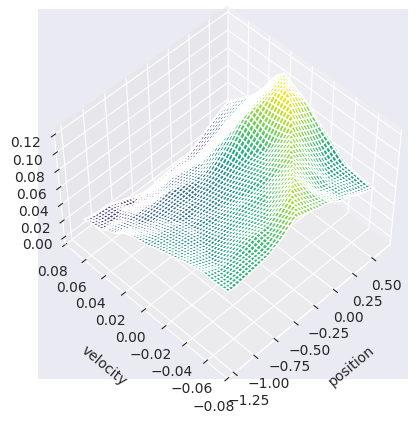

-200.0
Episode 100
Length: 200


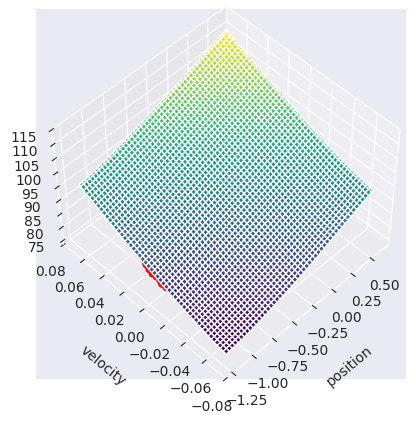

-200.0
Episode 200
Length: 200


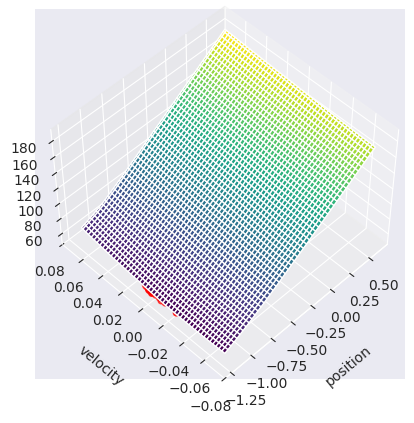

In [ ]:
# Environment setup
env = gym.make('MountainCar-v0')

# Hyperparameters
alpha = 0.0001
gamma = 1
epsilon = 0.15
nb_episodes = 300


# Initialize model, optimizer, and loss function
state, _ = env.reset()
norm_state = featurize(state)
n_states = len(norm_state[0])
n_actions = 3
model = FeedForwardNetwork(
    input_dim=n_states,
    output_dim=n_actions
)
optimizer = optim.SGD(model.parameters(), lr=alpha)
mse = nn.MSELoss()

# Training loop
visited_states = []

for j in tqdm(range(nb_episodes)):
    k = 0
    rewards = 0
    state, _ = env.reset()

    while True:
        next_state, reward, done, action, action_values = interact(
            env = env,
            state=state,
            model=model,
            deterministic=False,
            epsilon=epsilon
        )

        _ = learn(
            model=model,
            state=state,
            next_state=next_state,
            reward=reward,
            done=done,
            action=action,
            gamma=gamma,
            epsilon=epsilon,
            optimizer=optimizer,
            loss_function=mse
        )

        k += 1
        visited_states.append(state.tolist())
        rewards += reward

        state = next_state

        if done:
            if j % 100 == 0:
                print(rewards)
                print(f"Episode {j}")
                print(f"Length: {k}")
                plot_surface(model, n_states, np.array(visited_states), featurize)
            break

    env.close()

Use the following cell to test the greedy-execution scenario.

In [ ]:
env = gym.make('MountainCar-v0', render_mode="human")
state, _ = env.reset()

k = 0

while True:
    env.render()
    k += 1

    action, _ = policy(state, model, deterministic=True, epsilon=epsilon)

    # Take the action in the environment
    state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

    if done:
        break

print(k)
env.close()

200


## Solution 1)

Since extrapolation/generalization is very dominant with simple features, the (action-)value of many unseen states is based on the seen reward of a few states around the initial position. This will tear down the action-value estimation within the whole state space, which negates any optimistic parameter initialization. Therefore, inherent exploration based on action-values that are initialized to high values as we have seen it in the first exercises (e.g. in the MonteCarlo Racetrack scenario) will not be performed here and exploration will be halted rather soon.

## 2) Feature Engineering in Function Approximation

As you may have seen, on-policy control is so much more complicated than prediction because some simple features as in task 1 will not always do the trick. A problem that can often be seen in cases like this originates from the generalization aspect of the ANN. Usually, generalization is an advantage, but we have to explore the state space sufficiently to enable its validity. In the MountainCar scenario, the state space can not be explored with simple means because reaching a specific state is always bound to preconditions.

In order to overcome this generalization dilemma, a very different feature encoding can be employed. This can be done in the form of e.g. radial basis functions (RBFs), using RBF-feature
$x_i = e^{-\frac{||x - c_\mathrm{i}||^2}{2 \sigma_\mathrm{i}^2}}$.

For more information, you can read up in the Sutton and Barto (page 221 ff.).

![](RBF.png)
(Source: Reinforcement Learning, Sutton&Barto, p.221)

With this encoding the feature vector will get very large, meaning that the dependency of the ANN output on single feature components will decrease. Contrary to just using the states as features, this will decrease the ANNs ability to extrapolate to unseen areas, because a very different set of features will be "active" within different regions of the state space.

The following cell will prepare an RBF featurizer for the given state space. You should be able to use the same training algorithm as in task 1. (And if you happened to give up on task 1 before preparing a training algorithm, you now still have the chance to write one :P ).
Show the learning curves (mean and standard deviation) as function of steps per episode! Therefore, evaluate multiple independent learning runs to retrieve the information required for plotting.  

In [ ]:
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

featurizer = sklearn.pipeline.FeatureUnion([
    ("rbf0", RBFSampler(gamma=5.0, n_components = 100)),
    ("rbf1", RBFSampler(gamma=2.0, n_components = 100)),
    ("rbf2", RBFSampler(gamma=1.0, n_components = 100)),
    ("rbf3", RBFSampler(gamma=0.5, n_components = 100)),
    ])
featurizer.fit(scaler.transform(observation_examples))


def featurize(state):
    try:
        scaled = scaler.transform([state])
    except:
        print(state)
    featurized = featurizer.transform(scaled)
    return featurized

Function to measure the performance using greedy execution.

In [ ]:
def performance_measure(model, env, measure_len=20, epsilon=0):
    k_vec = np.zeros(measure_len)

    for i in range(measure_len):
        k = 0
        state, _ = env.reset()

        while True:
            k += 1
            action, _ = policy(state, model, deterministic=False, epsilon=epsilon)

            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            if done:
                k_vec[i] = k
                break

    return np.mean(k_vec), np.std(k_vec)

In [ ]:
nb_episodes = 300
nb_perf_meas = 5

performance_matrix = np.zeros((nb_episodes, nb_perf_meas))
best_performance = np.zeros((nb_perf_meas, 2))

env = gym.make('MountainCar-v0')
# Input dimension has changed due to different featurization
state, _ = env.reset()
norm_state = featurize(state)
n_states = len(norm_state[0])
n_actions = 3


for m in tqdm(range(nb_perf_meas)):

    model = FeedForwardNetwork(input_dim=n_states, output_dim=n_actions)
    optimizer = optim.SGD(model.parameters(), lr=alpha)
    mse_loss = nn.MSELoss()

    visited_states = []

    for j in tqdm(range(nb_episodes)):
        k = 0
        rewards = 0

        state, _ = env.reset()

        while True:

            next_state, reward, done, action, action_values = interact(
                env=env,
                state=state,
                model=model,
                deterministic=False,
                epsilon=epsilon
            )

            _ = learn(
                model=model,
                state=state,
                next_state=next_state,
                reward=reward,
                done=done,
                action=action,
                gamma=gamma,
                epsilon=epsilon,
                optimizer=optimizer,
                loss_function=mse
            )

            k += 1
            visited_states.append(state.tolist())
            rewards += reward

            state = next_state

            if done:
                performance_matrix[j, m] = k
                if j % 100 == 0:
                    print(rewards)
                    print(f"Episode {j}")
                    print(f"Length: {k}")
                    plot_surface(model, n_states, np.array(visited_states), featurize)

                break

    best_performance[m][0], _ = performance_measure(model, env, epsilon=0)
    best_performance[m][1], _ = performance_measure(model, env, epsilon=0.15)

env.close()

Output hidden; open in https://colab.research.google.com to view.

Show the performance over the episodes of the 10 runs (average +- standard deviadtion):

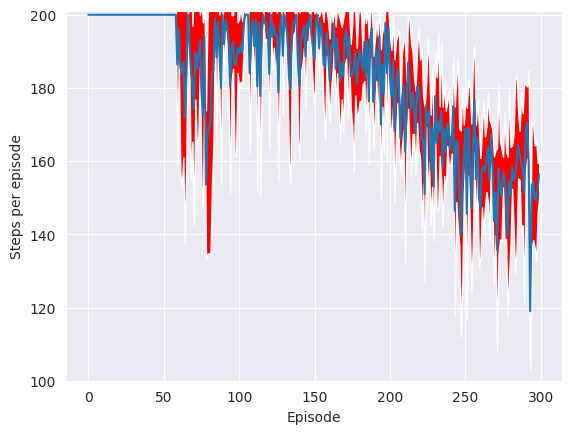

In [ ]:
fig, axs = plt.subplots()
epochs = list(range(300))
perf_mean = (np.mean(performance_matrix, axis = 1))
perf_std = np.std(performance_matrix, axis = 1)


axs.plot(epochs, perf_mean)
axs.fill_between(epochs, perf_mean-perf_std, perf_mean+perf_std, facecolor='r')
axs.set_ylim([100,201])
plt.ylabel('Steps per episode')
plt.xlabel('Episode')
plt.show()

The following plots show boxplots of the greedy and epsilon-greedy ($\epsilon = 0.15$) execution of the 20 trained agents after 100 episodes:

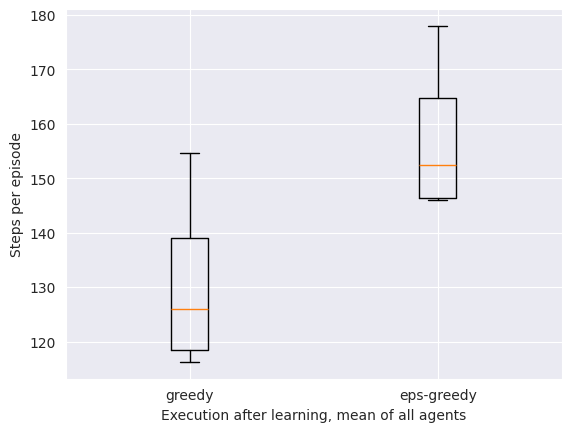

In [ ]:
plt.boxplot( best_performance)
plt.ylabel('Steps per episode')
plt.xlabel('Execution after learning, mean of all agents')
plt.xticks([1, 2], ['greedy', 'eps-greedy'])
plt.show()

In [ ]:
env.close()

env = gym.make('MountainCar-v0', render_mode="human")
state, _ = env.reset()

k = 0

while True:
    env.render()
    k += 1

    next_state, reward, done, action, action_values = interact(env, state, model, deterministic=True, epsilon=epsilon)

    state = next_state

    if done:
        break

print(k)
env.close()


122


## 3)  Feature Engineering in Linear Approximation with Online LSPI

As we have seen, the RBF feature engineering allows for good trainability of the ANN. Maybe, a similar result can even be achieved with the use of a linear function approximator if this feature encoding is reused.

As we cannot encode the action itself with the same RBF method, we still needed to apply a change to the `featurize` function, such that the estimate can take the action properly into account. Please investigate the new `featurize` function and try to understand the motivation behind it.

Write an RLS-SARSA algorithm to train a linear function approximator that estimates the action value and enables on-policy control.
Show the learning curves (mean and standard deviation) as function of steps per episode. Therefore, evaluate multiple independent learning runs to retrieve the information required for plotting.
Compare the two algorithms!


In [ ]:
def performance_measure_LSPI(w_policy,measure_len=20, epsilon=0):
    k_vec = np.zeros(measure_len)

    for i in range(measure_len):

        k = 0
        state, _ = env.reset()

        while True:
            k += 1
            _, action = policy(state, w_policy, env.action_space.n, True, epsilon)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            if done:
                k_vec[i] = k
                break

    return np.mean(k_vec), np.std(k_vec)

def plot_surface_LSPI(w, input_dim):
    resolution = 100
    pos_vec = np.linspace(-1.2, 0.6, resolution)
    vel_vec = np.linspace(-0.07, 0.07, resolution)

    pos_mat, vel_mat = np.meshgrid(pos_vec, vel_vec)
    value_tensor = np.zeros([resolution, resolution])

    for pos_idx, pos in enumerate(pos_vec):
        for vel_idx, vel in enumerate(vel_vec):
            feat_state, _ =  policy(np.array([pos, vel]), w, env.action_space.n, True, 0)
            value_tensor[vel_idx, pos_idx] = np.transpose(feat_state) @ w

    # Plot
    fig = plt.subplots()
    ax = plt.axes(projection='3d')
    ax.plot_surface(pos_mat, vel_mat, -value_tensor, cmap="viridis")
    ax.set_xlabel('\n\nposition')
    ax.set_ylabel('\n\nvelocity')
    ax.set_zlabel(r'$-V_\mathrm{greedy}$', labelpad=12)
    ax.view_init(50, -135)
    plt.show()

In [ ]:
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

featurizer = sklearn.pipeline.FeatureUnion([
    ("rbf0", RBFSampler(gamma=5.0, n_components = 100)),
    ("rbf1", RBFSampler(gamma=2.0, n_components = 100)),
    ("rbf2", RBFSampler(gamma=1.0, n_components = 100)),
    ("rbf3", RBFSampler(gamma=0.5, n_components = 100)),
    ])
featurizer.fit(scaler.transform(observation_examples))


def featurize(state, action):
    """Applies the RBF featurizer to the state and adds a featurized action as well."""
    action_vec = np.zeros([3, 1])
    action_vec[action] = 1

    win = 0
    if state[0] > 0.5:
        win = 1

    try:
        scaled = scaler.transform([state])
    except:
        print(state)
    featurized = featurizer.transform(scaled)
    featurized = np.reshape(featurized, (-1, 1)) # make column vector

    featurized = np.append(featurized, np.array([[1]]), axis = 0)

    featurized_vec = np.array([])
    featurized_vec = np.expand_dims(featurized_vec, axis=-1)
    for a in action_vec:
        if a == 1:
            featurized_vec = np.append(featurized_vec, featurized, axis = 0)
        elif a == 0:
            featurized_vec = np.append(featurized_vec, np.zeros([len(featurized), 1]), axis = 0)

    return featurized_vec * (1 - win)


def policy(state, w, n, deterministic, epsilon):
    """Decides on an action in dependence of the current state.

    Args:
        state: The current state
        w: The parameters of the model
        n: The number of possible actions
        deterministic: Whether the action is chosen deterministically or epsilon-greedily
        epsilon: Probability for random action in eps-greedy

    Returns:
        feat_states: The featurizes
        action: The chosen action
    """
    # used to store the featurized states for each possible state,
    # the featurized state is to be used to compute the q-values
    # and which action will be chosen is only known after the
    # q-value calculation
    feat_states = np.zeros([len(w), n, 1])
    q_value = np.zeros([n])

    ### BEGIN SOLUTION

    for i in range(n):
        feat_state = featurize(state, i)
        feat_states[:, i] = feat_state
        q_value[i] = np.transpose(feat_state) @ w

    if epsilon < np.random.rand(1) or deterministic:
        action = np.argmax(q_value)
    else:
        action = random.choice(range(n))

    ### END SOLUTION

    return feat_states[:, action], action


def learn(w, P, feat_state, feat_next_state, feat_dims, gamma, _lambda):
    """Update the parameter set and P matrix with the RLS update rule with the data
    from the last iteration.

    Args:
        w: Weight parameters
        P: P-matrix
        feat_state: The featurized state before the interaction
        feat_next_state: The featurized state after the interaction
        feat_dims: The dimensionality of the featurized state
        gamma: Discount factor
        _lambda: Forgetting factor

    Returns:
        w: Updated parameters
        P: Updated P-matrix
    """
    ### BEGIN SOLUTION

    y = reward
    xi = feat_state - gamma * feat_next_state
    c = (P @ xi) / (_lambda + np.squeeze(np.transpose(xi) @ P @ xi))
    w += c * np.squeeze(y - np.transpose(xi) @ w)
    P = (np.eye(feat_dims) - c @ np.transpose(xi)) @ P / _lambda

    ### END SOLUTION
    return w, P

In [ ]:
gamma = 1
# try lambda < 1, what do you see?
_lambda = 1
nb_episodes = 100
epsilon = 0.15
k_w = 10
nb_perf_meas = 5

env = gym.make('MountainCar-v0')
state, _ = env.reset()
feat_state = featurize(state, 0)
feat_dims = len(feat_state)

performance_matrix_ = np.zeros((nb_episodes, nb_perf_meas))
best_performance = np.zeros((nb_perf_meas,2))

for m in tqdm(range(nb_perf_meas)):
    k = 0
    P = np.eye(feat_dims)
    w = np.zeros(feat_dims)
    w = np.expand_dims(w, axis=-1)

    w_policy = np.copy(w)

    for j in tqdm(range(nb_episodes)):

        length = 0

        state, _ = env.reset()
        feat_state, action = policy(state, w, env.action_space.n, False, epsilon)

        while True:

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            feat_next_state, next_action = policy(next_state, w_policy, env.action_space.n, False, epsilon)

            w, P = learn(w, P, feat_state, feat_next_state, feat_dims, gamma, _lambda)
            if k % k_w == 0:
                w_policy = w

            # time propagation
            feat_state = feat_next_state
            state = next_state
            action = next_action

            k += 1
            length += 1

            if done:
                performance_matrix_[j,m] = length
                if j % 25 == 0:
                    plot_surface_LSPI(w, feat_dims)
                break

    best_performance[m][0], _ = performance_measure_LSPI(w_policy, epsilon=0)
    best_performance[m][1], _ = performance_measure_LSPI(w_policy, epsilon=0.15)

    env.close()

In [ ]:
env.close()
env = gym.make('MountainCar-v0', render_mode="human")
state, _ = env.reset()

k = 0

while True:
    env.render()
    k += 1

    _, action = policy(state, w_policy, env.action_space.n,True, 0)
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    state = next_state

    if done:
        break

print(k)
env.close()

Show the performance over the episodes of the 20 runs (average +- standard deviadtion):

In [ ]:
fig, axs = plt.subplots()
epochs = list(range(100))
perf_mean = (np.mean(performance_matrix_, axis = 1))
perf_std = np.std(performance_matrix_, axis = 1)


axs.plot(epochs, perf_mean)
axs.fill_between(epochs, perf_mean-perf_std, perf_mean+perf_std, facecolor='r')
axs.set_ylim([100,201])
plt.ylabel('Steps per episode')
plt.xlabel('Episode')
plt.show()

The following plots show boxplots of the greedy and epsilon-greedy ($\epsilon = 0.15$) execution of the 20 trained agents after 100 episodes:

In [ ]:
plt.boxplot( best_performance)
plt.ylabel('Steps per episode')
plt.xlabel('Execution after learning, mean of all agents')
plt.xticks([1, 2], ['greedy', 'eps-greedy'])
plt.show()


The use of an appropriate RBF feature engineering enables even a linear agent to solve the MountainCar environment. Since the policy is changing over time, it would be useful to set the $\lambda$-parameter lower than one. However, this can lead to numeric instability, so this degree of freedom has to be tuned with caution. With $\lambda=1$, all observations are weighted equally, which does not accurately describe the behavior of our changing policy. Nonetheless, the resulting estimator is able to perform acceptable on-policy control. With a rising number of training episodes, even the $\lambda=1$ training will converge to the correct action-value eventually (but we do not know how many episodes this may need).